In [1]:
cd /home

/home


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Sampling random windows

In [4]:
def sample_lc(sequence, max_obs):
    '''
    Sample a random window of "max_obs" observations from the input sequence
    '''
    serie_len = tf.shape(sequence)[0]

    pivot = 0
    if tf.greater(serie_len, max_obs):
        pivot = tf.random.uniform([],
                                  minval=0,
                                  maxval=serie_len-max_obs+1,
                                  dtype=tf.int32)

        sequence = tf.slice(sequence, [pivot,0], [max_obs, -1])
    else:
        sequence = tf.slice(sequence, [0,0], [serie_len, -1])

    return sequence

In [5]:
times = tf.range(0, 15, dtype=tf.float32)
magnitudes = tf.sin(times)
sequence = tf.transpose(tf.stack([times, magnitudes], 0))

2021-11-14 17:53:59.980087: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2021-11-14 17:53:59.980181: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (153b5d94f976): /proc/driver/nvidia/version does not exist
2021-11-14 17:53:59.980675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


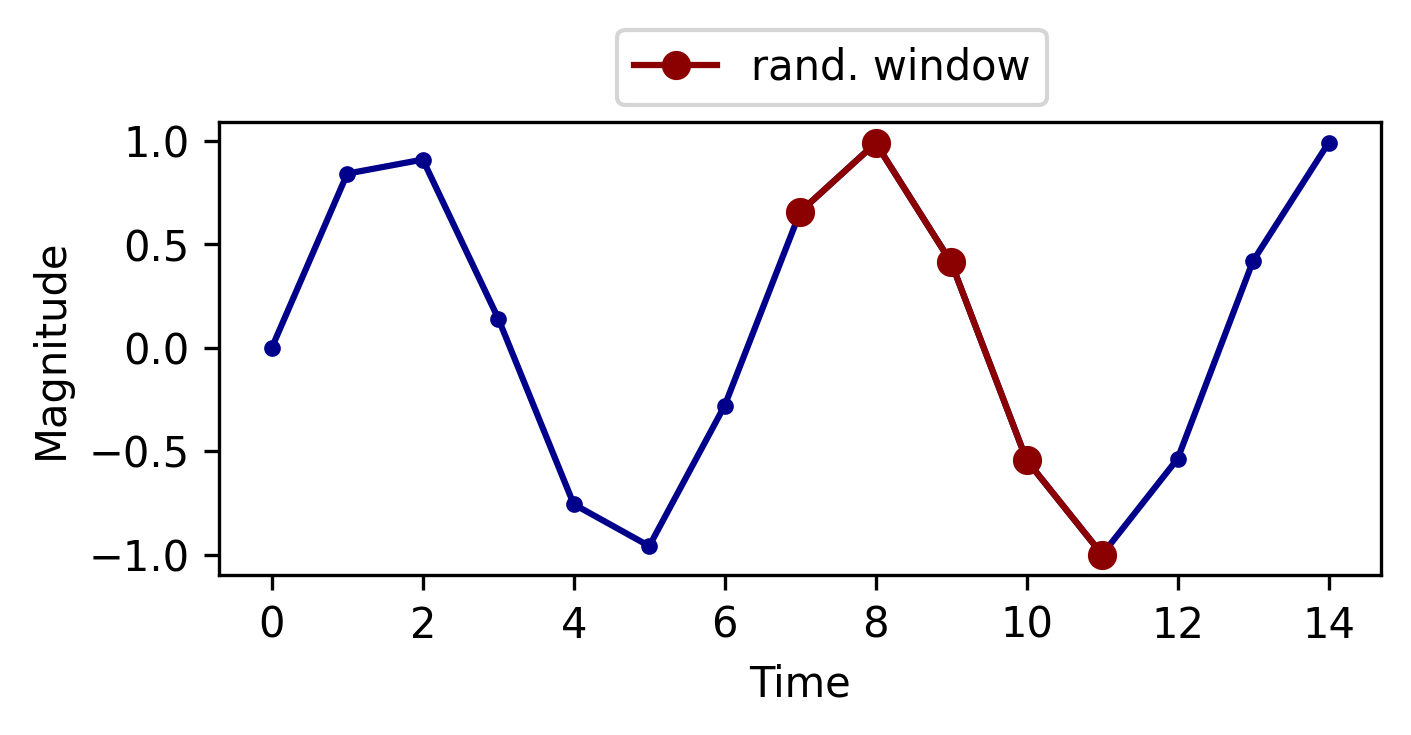

In [6]:
for i in range(20):
    plt.figure(figsize=(5,2), dpi=300)
    plt.plot(sequence[:, 0], sequence[:, 1], marker='.', color='darkblue')
    sample = sample_lc(sequence, max_obs=5)
    plt.plot(sample[:, 0], sample[:, 1], marker='o', color='darkred', label='rand. window')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend(bbox_to_anchor=(.73, 1.25))
#     plt.savefig('./presentation/figures/sampling/{}.png'.format(i), bbox_inches='tight', dpi=300)
    break

# Moving window

In [4]:
cd /home/users/cdonoso/astromer/ASTROMER/

/home/users/cdonoso/astromer/ASTROMER


In [5]:
import tensorflow as tf 

from core.data import pretraining_records

%load_ext autoreload
%autoreload 2

In [19]:
batches = pretraining_records('./data/records/alcock/train', 
                             16, 
                             shuffle=False, 
                             sampling=False,
                             max_obs=200,
                             msk_frac=0, 
                             rnd_frac=0, 
                             same_frac=0)

2021-11-14 17:56:35.292302: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


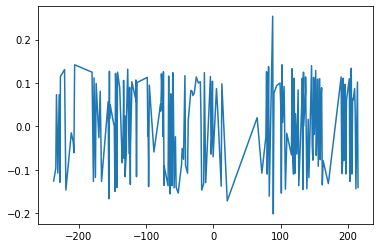

In [21]:
for batch in batches:
    plt.plot(batch['times'][0][...,0], batch['input'][0][...,0])
    break

#  create fold using saved att. vectors

In [8]:
cd ../..

/home/users/cdonoso/astromer/ASTROMER


In [3]:
import h5py
import numpy as np
import os

In [10]:
def load_embeddings(source):
    file = open(source, 'rb')
    hf = h5py.File(file)
    att = hf['att'][()]
    x = hf['x'][()]
    t = hf['t'][()]
    y = hf['y'][()]
    m = hf['m'][()]
    return att, y, m, x, t

In [11]:
source = './embeddings/alcock/'
target = './encoded/alcock'

In [23]:
att_train, y_train, m_train, x_train, t_train = load_embeddings(os.path.join(source, 'train.h5'))
att_val, y_val, m_val, x_val, t_val = load_embeddings(os.path.join(source, 'val.h5'))
att_test, y_test, m_test, x_test, t_test = load_embeddings(os.path.join(source, 'test.h5'))

print(att_train.shape)
print(att_val.shape)
print(att_test.shape)

(47107, 200, 256)
(23369, 200, 256)
(7855, 200, 256)


# Attention Layer

In [19]:
from core.astromer import ASTROMER
import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
astromer = ASTROMER()

In [21]:
conf_file = os.path.join('./weights/astromer_10022021/finetuning/alcock/', 'conf.json')
with open(conf_file, 'r') as handle:
    conf = json.load(handle)

In [22]:
config = {'num_layers' : conf['layers'],
          'd_model' : conf['head_dim'],
          'num_heads' : conf['heads'],
          'dff' : conf['dff'],
          'base' : conf['base'],
          'dropout' :conf['dropout'],
          'use_leak' : conf['use_leak'],
          'no_train' : conf['no_train'],
          'maxlen' : conf['max_obs']}

In [23]:
config_init = astromer.get_config()
config_init

{'num_layers': 2,
 'd_model': 200,
 'num_heads': 2,
 'dff': 256,
 'base': 10000,
 'dropout': 0.1,
 'use_leak': False,
 'no_train': True,
 'maxlen': 100}

In [24]:
astromer = astromer.from_config(config)

In [25]:
astromer.get_config()

{'num_layers': 2,
 'd_model': 256,
 'num_heads': 4,
 'dff': 128,
 'base': 1000,
 'dropout': 0.1,
 'use_leak': False,
 'no_train': False,
 'maxlen': 200}

In [27]:
astromer

In [26]:
astromer.load_weights('./weights/astromer_10022021/finetuning/alcock/weights')

AssertionError: Nothing to load. No dependencies have been added to <core.astromer.ASTROMER object at 0x7f50a039cfa0> yet.